In [4]:
import json
import folium
import polyline
import pandas as pd

## Map global (Folium)

In [5]:


# Exemple d'une ligne map en string (ton contenu)
map_str = r'{ "id": "a15255160621", "resource_state": 2, "summary_polyline": "qsfsHywm^eEuDuBkEsCgPc@yPn@}Ao@Fj@cB@iG\\{CYeBT}B[oEx@eDFkCt@cCpFqKtEkNfAkBGm@yCeDeA}BaBu@sEsEwEsNcCcCeBw@WwHLgFcFyOFiErBcGt@gHsDEgBs@wCqIOqCeAqDkAaC{HaG{ANcA~@}A`FwAxAiCr@}NX{@K}BcD{E_Dg@cAuC{@u@kAXcDZD~AzBdDqB@o@u@?DcBn@_@^gAMeBUc@I_DoCiLn@eCvBgBrBsG~BsPbBeFTsE|@sDPiE|AgGlO|Ac@zMb@tKq@pHhAbHLxJg@I^\\nAyDbBlAbAnDrAnKjBoApEpClGxIzAdExBvBBh@YxAiAvA_IzAgFN_IsCeBdAeAdEyAxBwPlB{CUu@eBPs@jE_EjG`BhAsApE{B~@wAsAcKe@uGp@wKVeA|@s@z@{Fn@q@s@lAg@bDBy@m@}Ab@qJeAiGf@_Gc@sQl@iH~FIzBwDxAiBlD}CzGNdDd@|BYjBvEbCtKhAdQnApCdDlDd@lBpAhOi@tOdBjIY~EjA`HfEzMYlCw@dB_Ej@]rA}@HFZ`CrCvHlFxE|AnCLhBgAlA{B|FqAA}@`Ak@z@yChB{@|FRv@kDxGgCbApAlAxDrPlk@F~A}CdC{A|CzArC~A|@G`@cC|BoAfD}A~AiC`AgFXsByA~At@hFPsCzAqFg@gF`DyJjAyI`GuFjHbChDtD`H}@bCzCdH?f@aAtAjAhEnHzIjDzG[zHjC~R@bCc@d@kGnCeJnG`GhJvD|CbKaBpBPhBvAbBe@tCn@|BbKv@tHlEdMpC|CjGjNbAt@lB[nAhA}@j`@Z~I}@jONbAf@bA`BYvCzD`DnFd@rFlBlB@rAe@hBXkANHz@fCdJ`h@z@zBlCvAnA~F~AvDI|Ci@lBiEvGmE|Cn@zK{EJyAl@wAkHMmFkBuG?mH_B}F_AcIuEqKoCmEuH_LiAAoCeIoB{@gMC|C[sJL{@iEoBIa@gAx@p@JhAx@lAAz@{DAOgAeE{CgI~BeBMo@}DdEWnAe@fAgBFcBv@yAhCxB`IxBlBhBtAXbBs@pHi@zCeB|BkDh@qBm@sBr@uC}AUaB|@aDeAyBt@o@y@m@\\mB{IiBeADeEqA{T@mE`@yDm@mFA}CuE}@kJj@yC}@cBcCiHkR}HrIHsBa@m@c@bAmH_@yA}Am@sDWMoBFu@nBo@cL_A{BlCXFaA`A]h@wBdA@z@oAzBlA"}'

# Étape 1 : Parser le JSON
map_json = json.loads(map_str)

# Étape 2 : Extraire la polyline
polyline_str = map_json.get("summary_polyline")

# Étape 3 : Décoder la polyline en liste de (lat, lon)
coords = polyline.decode(polyline_str)

# Étape 4 : Créer une carte centrée sur le premier point
m = folium.Map(location=coords[0], zoom_start=13)

# Ajouter la trace du parcours
folium.PolyLine(coords, color="blue", weight=3).add_to(m)

# Afficher la carte (dans un Jupyter Notebook par exemple)
m


In [6]:

def create_latest_activity_map(df):
    """
    Crée une carte Folium de la dernière activité de type 'Trail' selon la date 'start_date'.

    Args:
        df (pd.DataFrame): DataFrame contenant au minimum les colonnes 'map' (dict ou JSON string),
                           'sport_type' (str), et 'start_date' (datetime).

    Returns:
        folium.Map ou None : Carte avec la trace de l'activité, ou None si polyline absente.
    """
    # Filtrer uniquement les activités TrailRun
    df_trailrun = df[df['sport_type'] == 'Trail']

    if df_trailrun.empty:
        print("Aucune activité TrailRun trouvée.")
        return None

    # Trier par date décroissante (plus récente en premier)
    df_sorted = df_trailrun.sort_values('start_date', ascending=False)

    # Récupérer la dernière activité
    latest_activity = df_sorted.iloc[0]

    # Récupérer la colonne 'map' et s'assurer que c'est un dict
    map_data = latest_activity['map']
    if isinstance(map_data, str):
        try:
            map_data = json.loads(map_data)
        except Exception as e:
            print(f"Erreur lors du chargement JSON de la colonne 'map' : {e}")
            return None

    # Extraire la polyline
    polyline_str = map_data.get('summary_polyline')
    if not polyline_str:
        print("Pas de polyline disponible pour cette activité.")
        return None

    # Décoder la polyline en liste de coordonnées (lat, lon)
    coords = polyline.decode(polyline_str)

    # Créer la carte centrée sur le premier point de la trace
    m = folium.Map(location=coords[0], zoom_start=13)

    # Ajouter la trace polyline
    folium.PolyLine(coords, color='blue', weight=5).add_to(m)

    return m


In [7]:
df = pd.read_csv("/Users/arthurdercq/code/Data Science/Garmin_Dashboard/data/clean_data_2025-08-28.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/arthurdercq/code/Data Science/Garmin_Dashboard/data/clean_data_2025-08-28.csv'

In [ ]:
create_latest_activity_map(df)

In [ ]:
import json
import polyline
import matplotlib.pyplot as plt
import datetime

def create_latest_activity_poster(df, sport_type):
    """
    Crée une affiche minimaliste (statique) de la dernière activité Trail.

    Args:
        df (pd.DataFrame): DataFrame contenant au minimum :
                           - 'map' (dict ou JSON string avec 'summary_polyline')
                           - 'sport_type' (str)
                           - 'start_date' (datetime)
                           - 'distance' (float, en km)
                           - 'elapsed_time_hms' (formatée)
        save_path (str): chemin d'export de l'image finale (PNG).
    """

    df_sport = df[df['sport_type'] == sport_type]

    if df_sport.empty:
        print("Aucune activité Trail trouvée.")
        return None

    # Trier par date décroissante
    df_sorted = df_sport.sort_values('start_date', ascending=False)
    latest_activity = df_sorted.iloc[0]

    latest_activity_date = latest_activity["start_date"]
    latest_activity_date = pd.to_datetime(latest_activity_date)
    latest_activity_date_str = latest_activity_date.strftime("%d/%m/%Y")

    # Charger map
    map_data = latest_activity['map']
    if isinstance(map_data, str):
        try:
            map_data = json.loads(map_data)
        except Exception as e:
            print(f"Erreur JSON dans map : {e}")
            return None

    # Extraire polyline
    polyline_str = map_data.get("summary_polyline")
    if not polyline_str:
        print("Pas de polyline disponible.")
        return None

    coords = polyline.decode(polyline_str)
    lats, lons = zip(*coords)

    # Distance et temps
    distance = latest_activity.get("distance", None)
    elapsed_time = latest_activity.get("elapsed_time_hms", None)
    dplus = latest_activity.get("total_elevation_gain", None)



    # --- 🎨 Création affiche ---
    fig, ax = plt.subplots(figsize=(8, 10))

    # Trace minimaliste
    ax.plot(lons, lats, color="white", linewidth=2)

    # Supprimer axes
    ax.set_axis_off()
    ax.set_facecolor("black")


    # Nom de l'activité en haut
    fig.text(
        0.5, 0.95,              # 95% de la hauteur de la figure
        latest_activity["name"], # nom de l'activité
        ha="center",
        va="top",
        color="white",
        fontsize=20,
        family="monospace"
    )
    # Ajouter infos
    if distance is not None and elapsed_time is not None and dplus is not None:
        plt.text(
            0.5, -0.05,
            f"{distance:.1f} km | {elapsed_time} | {dplus:.0f} m D+",  # si distance en m → km
            ha="center", va="top", transform=ax.transAxes,
            color="white", fontsize=16, family="monospace"
        )

        # Date en dessous
    fig.text(
        0.5, 0.015,  # légèrement plus bas
        latest_activity_date_str,    # formatée en "JJ/MM/AAAA"
        ha="center",
        va="bottom",
        color="white",
        fontsize=9,  # plus petite
        family="monospace"
)

    # Export
    plt.savefig("affiche_trail.png", dpi=300, bbox_inches="tight", facecolor="black")
    return fig, print(distance, elapsed_time, dplus, latest_activity_date_str)


18.91 01:48:15 338.0 24/08/2025


(<Figure size 800x1000 with 1 Axes>, None)

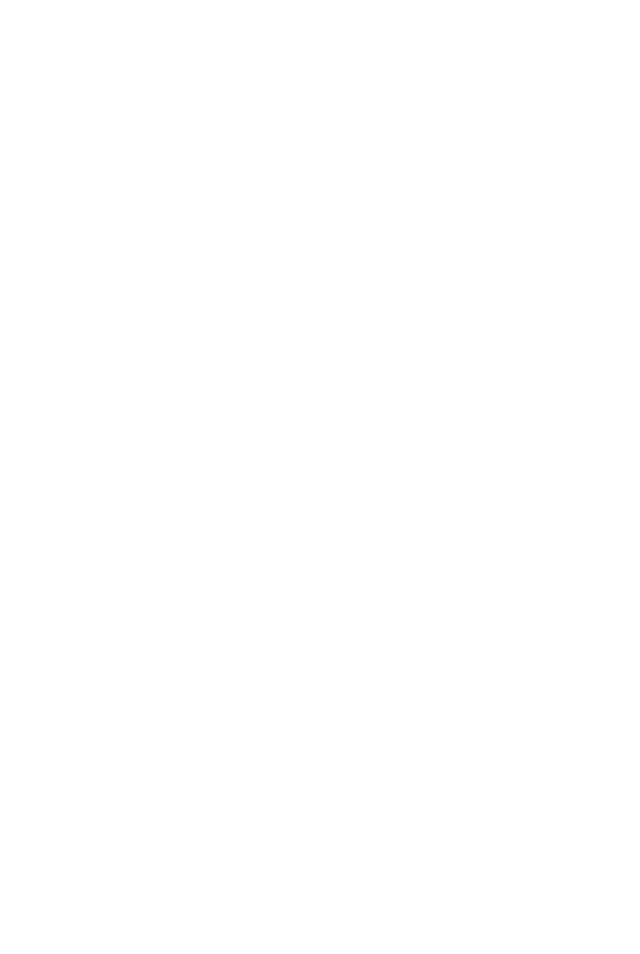

In [ ]:
fig = create_latest_activity_poster(df, "Trail")
fig

In [ ]:
import json
import polyline
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString

def create_latest_activity_poster_test(df, sport_type):
    """
    Crée une affiche minimaliste (statique) de la dernière activité Trail avec fond map noir/blanc.
    """

    df_sport = df[df['sport_type'] == sport_type]

    if df_sport.empty:
        print("Aucune activité Trail trouvée.")
        return None

    # Trier par date décroissante
    df_sorted = df_sport.sort_values('start_date', ascending=False)
    latest_activity = df_sorted.iloc[0]

    latest_activity_date = pd.to_datetime(latest_activity["start_date"])
    latest_activity_date_str = latest_activity_date.strftime("%d/%m/%Y")

    # Charger map
    map_data = latest_activity['map']
    if isinstance(map_data, str):
        try:
            map_data = json.loads(map_data)
        except Exception as e:
            print(f"Erreur JSON dans map : {e}")
            return None

    # Extraire polyline
    polyline_str = map_data.get("summary_polyline")
    if not polyline_str:
        print("Pas de polyline disponible.")
        return None

    coords = polyline.decode(polyline_str)

    # Convertir coords (lat, lon) → (lon, lat)
    line_coords = [(lon, lat) for lat, lon in coords]

    # GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=[LineString(line_coords)], crs="EPSG:4326")
    gdf = gdf.to_crs(epsg=3857)



    # Distance et temps
    distance = latest_activity.get("distance", None)
    elapsed_time = latest_activity.get("elapsed_time_hms", None)
    dplus = latest_activity.get("total_elevation_gain", None)

    # --- 🎨 Création affiche ---
    fig, ax = plt.subplots(figsize=(8, 10))

    # Plot polyline
    gdf.plot(ax=ax, color="white", linewidth=2)

    # Ajouter fond noir & blanc
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter)  # fond sombre
    ax.set_axis_off()

    # Nom de l'activité en haut
    fig.text(
        0.5, 0.95,
        latest_activity["name"],
        ha="center", va="top",
        color="white", fontsize=20, family="monospace"
    )

    # Ligne principale : distance, temps, D+
    if distance is not None and elapsed_time is not None and dplus is not None:
        fig.text(
            0.5, 0.03,
            f"{distance:.1f} km | {elapsed_time} | {dplus:.0f} m D+",
            ha="center", va="bottom",
            color="white", fontsize=16, family="monospace"
        )

    # Date en dessous
    fig.text(
        0.5, 0.015,
        latest_activity_date_str,
        ha="center", va="bottom",
        color="white", fontsize=9, family="monospace"
    )

    # Export
    plt.savefig("affiche_trail.png", dpi=300, bbox_inches="tight", facecolor="black")

    return fig


In [ ]:
create_latest_activity_poster_test(df, "Trail")

TypeError: can only be called with ndarray object

## Elevation Facets

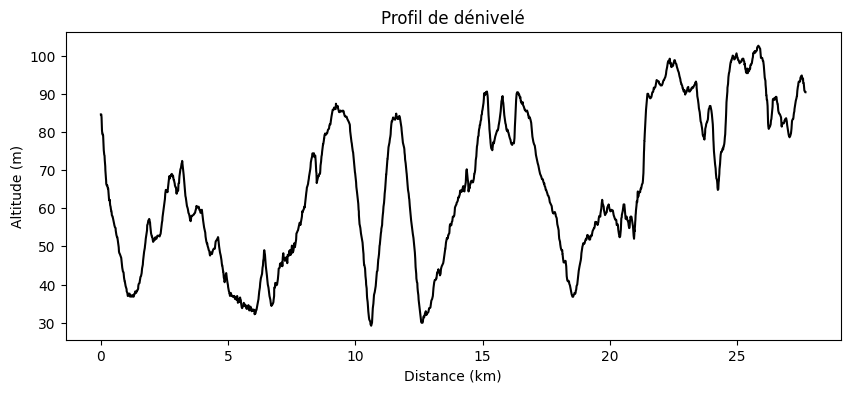

In [ ]:
import gpxpy
import matplotlib.pyplot as plt
import numpy as np

with open("activity_test.gpx", "r") as f:
    gpx = gpxpy.parse(f)

# Récupération des points
lats, lons, elevs = [], [], []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lats.append(point.latitude)
            lons.append(point.longitude)
            elevs.append(point.elevation)

# Distance cumulée
dist = [0]
for i in range(1, len(lats)):
    d = np.sqrt((lats[i]-lats[i-1])**2 + (lons[i]-lons[i-1])**2) * 111_000  # approx en mètres
    dist.append(dist[-1] + d)

# Tracé profil
plt.figure(figsize=(10,4))
plt.plot(np.array(dist)/1000, elevs, color="black")
plt.xlabel("Distance (km)")
plt.ylabel("Altitude (m)")
plt.title("Profil de dénivelé")
plt.show()


/Users/arthurdercq/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.strava.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Access Token = 68a577f8ab5d2de5044afa80d0a5e77b47aa8f67



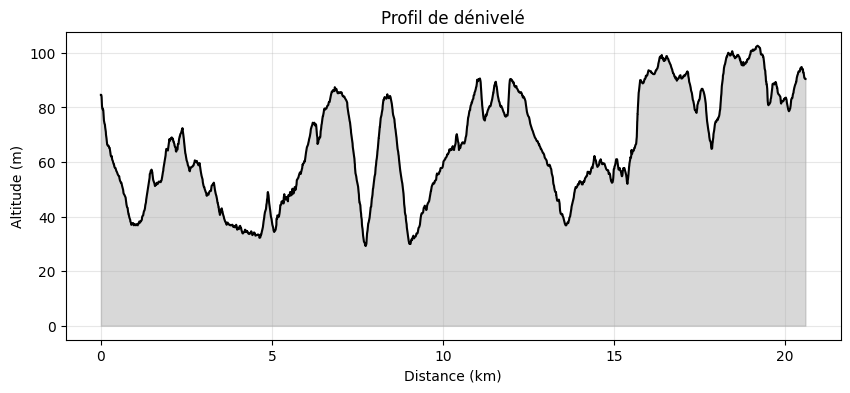

In [ ]:
import requests
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 1. Paramètres à remplir
# ----------------------------
ACTIVITY_ID = "15624755365"           # ID de ton activité Strava
AUTH_URL ="https://www.strava.com/oauth/token"
STRAVA_CLIENT_ID="114062"
STRAVA_CLIENT_SECRET="3ff69d1668764ef3f5ebdfbe71ecc04bf694d74c"
STRAVA_REFRESH_TOKEN="e4a08d7904a3eedba9782ee6aa7b8644898beaff"
# ----------------------------
# 2. Récupération des streams
# ----------------------------

payload = {
    'client_id': STRAVA_CLIENT_ID,
    'client_secret': STRAVA_CLIENT_SECRET,
    'refresh_token': STRAVA_REFRESH_TOKEN,
    'grant_type': "refresh_token",
    'f': 'json'
    }
res = requests.post(AUTH_URL, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

url = f"https://www.strava.com/api/v3/activities/{ACTIVITY_ID}/streams"
params = {
    "keys": "latlng,altitude,distance,time",
    "key_by_type": "true"
}
headers = {"Authorization": f"Bearer {access_token}"}

resp = requests.get(url, params=params, headers=headers)
resp.raise_for_status()
streams = resp.json()

latlng = streams.get("latlng", {}).get("data", [])
altitude = streams.get("altitude", {}).get("data", [])
distance = streams.get("distance", {}).get("data", [])

if not altitude or not distance:
    raise ValueError("⚠️ Pas de données altitude/distance dans cette activité !")

# ----------------------------
# 3. Tracé du profil de dénivelé
# ----------------------------
plt.figure(figsize=(10,4))
plt.plot(np.array(distance)/1000, altitude, color="black")
plt.fill_between(np.array(distance)/1000, altitude, alpha=0.3, color="gray")

plt.xlabel("Distance (km)")
plt.ylabel("Altitude (m)")
plt.title("Profil de dénivelé")
plt.grid(alpha=0.3)
plt.show()


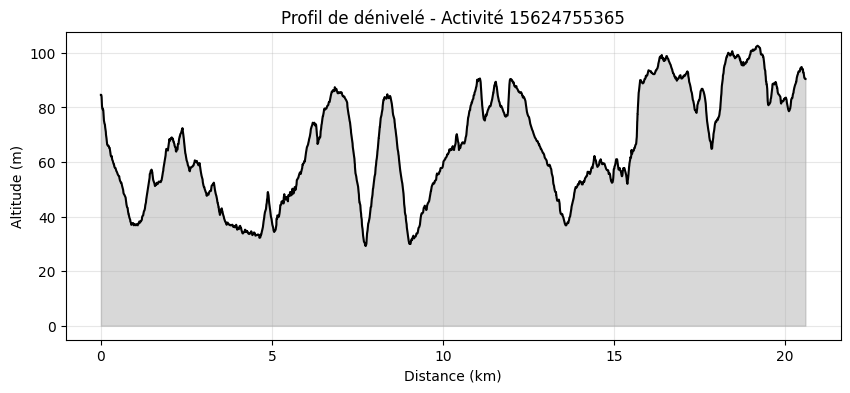

In [ ]:
#Le stream pour 1 seule activité

activity_id = "15624755365"
url = f"https://www.strava.com/api/v3/activities/{activity_id}/streams"
params = {"keys": "latlng,altitude,distance,time", "key_by_type": "true"}
resp = requests.get(url, headers=headers, params=params)
resp.raise_for_status()
streams = resp.json()

latlng = streams.get("latlng", {}).get("data", [])
altitude = streams.get("altitude", {}).get("data", [])
distance = streams.get("distance", {}).get("data", [])
time = streams.get("time", {}).get("data", [])

# Construction DataFrame
df_stream = pd.DataFrame({
        "activity_id": activity_id,
        "lat": [pt[0] for pt in latlng] if latlng else None,
        "lon": [pt[1] for pt in latlng] if latlng else None,
        "altitude": altitude,
        "distance_m": distance,
        "time_s": time
    })

# ----------------------------
# 3. Tracé du profil de dénivelé
# ----------------------------
plt.figure(figsize=(10,4))

# Conversion en km directement depuis la colonne du DataFrame
plt.plot(df_stream["distance_m"] / 1000, df_stream["altitude"], color="black")
plt.fill_between(df_stream["distance_m"] / 1000, df_stream["altitude"], alpha=0.3, color="gray")

plt.xlabel("Distance (km)")
plt.ylabel("Altitude (m)")
plt.title(f"Profil de dénivelé - Activité {df_stream['activity_id'].iloc[0]}")
plt.grid(alpha=0.3)
plt.show()


### Pipeline plot elevation facet grid

In [28]:
df_trail = df[df["sport_type"] == "Trail"].sort_values("start_date", ascending=False)

# Extraire les IDs sous forme de liste
activity_ids = df_trail["id"].head(10).tolist()

activity_ids

[15624755365,
 15572139270,
 15533644587,
 15401570576,
 15255160621,
 15244378944,
 15163453200,
 15088018553,
 15014611632,
 14983051162]

In [15]:
import requests
ACTIVITY_ID = "15624755365"           # ID de ton activité Strava
AUTH_URL ="https://www.strava.com/oauth/token"
STRAVA_CLIENT_ID="114062"
STRAVA_CLIENT_SECRET="3ff69d1668764ef3f5ebdfbe71ecc04bf694d74c"
STRAVA_REFRESH_TOKEN="e4a08d7904a3eedba9782ee6aa7b8644898beaff"

payload = {
    'client_id': STRAVA_CLIENT_ID,
    'client_secret': STRAVA_CLIENT_SECRET,
    'refresh_token': STRAVA_REFRESH_TOKEN,
    'grant_type': "refresh_token",
    'f': 'json'
    }
res = requests.post(AUTH_URL, data=payload, verify=False)
access_token = res.json()['access_token']
headers = {"Authorization": f"Bearer {access_token}"}


def fetch_trail_streams(activity_ids, headers):
    """
    Récupère les streams (distance, altitude) pour une liste d'activités.

    Args:
        activity_ids (list): liste d'IDs d'activités Strava
        headers (dict): headers Strava API (Bearer token)

    Returns:
        dict: {activity_id: {"distance": [...], "altitude": [...]}}
    """
    streams_dict = {}
    for activity_id in activity_ids:
        url = f"https://www.strava.com/api/v3/activities/{activity_id}/streams"
        params = {"keys": "altitude,distance", "key_by_type": "true"}
        resp = requests.get(url, headers=headers, params=params)
        resp.raise_for_status()
        streams = resp.json()

        distance = streams.get("distance", {}).get("data", [])  # km
        altitude = streams.get("altitude", {}).get("data", [])  # m

        if distance and altitude:
            streams_dict[activity_id] = {"distance": distance, "altitude": altitude}

    return streams_dict


/Users/arthurdercq/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.strava.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [47]:
import math
import matplotlib.pyplot as plt

def plot_trail_profiles(streams_dict,df_trail, n_cols=5):
    """
    Trace les profils de dénivelé en version minimaliste artistique à partir des données déjà récupérées.

    Args:
        streams_dict (dict): {activity_id: {"distance": [...], "altitude": [...]} }
        n_cols (int): nombre de colonnes dans la grille
    """
    activity_ids = list(streams_dict.keys())
    n_activities = len(activity_ids)
    if n_activities == 0:
        print("Aucune donnée à tracer.")
        return

    n_rows = math.ceil(n_activities / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 2.5*n_rows), gridspec_kw={"wspace": 0.5, "hspace": 0.5})
    axes = axes.flatten()

    for i, activity_id in enumerate(activity_ids):
        data = streams_dict[activity_id]
        ax = axes[i]
        ax.plot(data["distance"], data["altitude"], color="black", linewidth=1)
        ax.fill_between(data["distance"], data["altitude"], alpha=0.2, color="gray")
        ax.axis("off")

        # --- Ajouter la date en semi-transparence
        date = df_trail.loc[df_trail["id"] == activity_id, "start_date"].iloc[0]
        x_pos = data["distance"][len(data["distance"]) // 2]  # au milieu du tracé
        y_pos = max(data["altitude"]) * 0.1                  # près du bas
        ax.text(
            x_pos, y_pos, date.strftime("%Y-%m-%d"),
            fontsize=8, color="black", alpha=0.3, ha="center", va="top"
        )

    # Supprimer axes vides
    for j in range(n_activities, len(axes)):
        fig.delaxes(axes[j])

    #plt.tight_layout(pad=0.1)
    plt.show()


In [ ]:
streams = fetch_trail_streams(activity_ids, headers)


In [37]:
df_trail = df[df["sport_type"] == "Trail"].sort_values("start_date", ascending=False).head(10)
df_trail["start_date"] = pd.to_datetime(df_trail["start_date"])


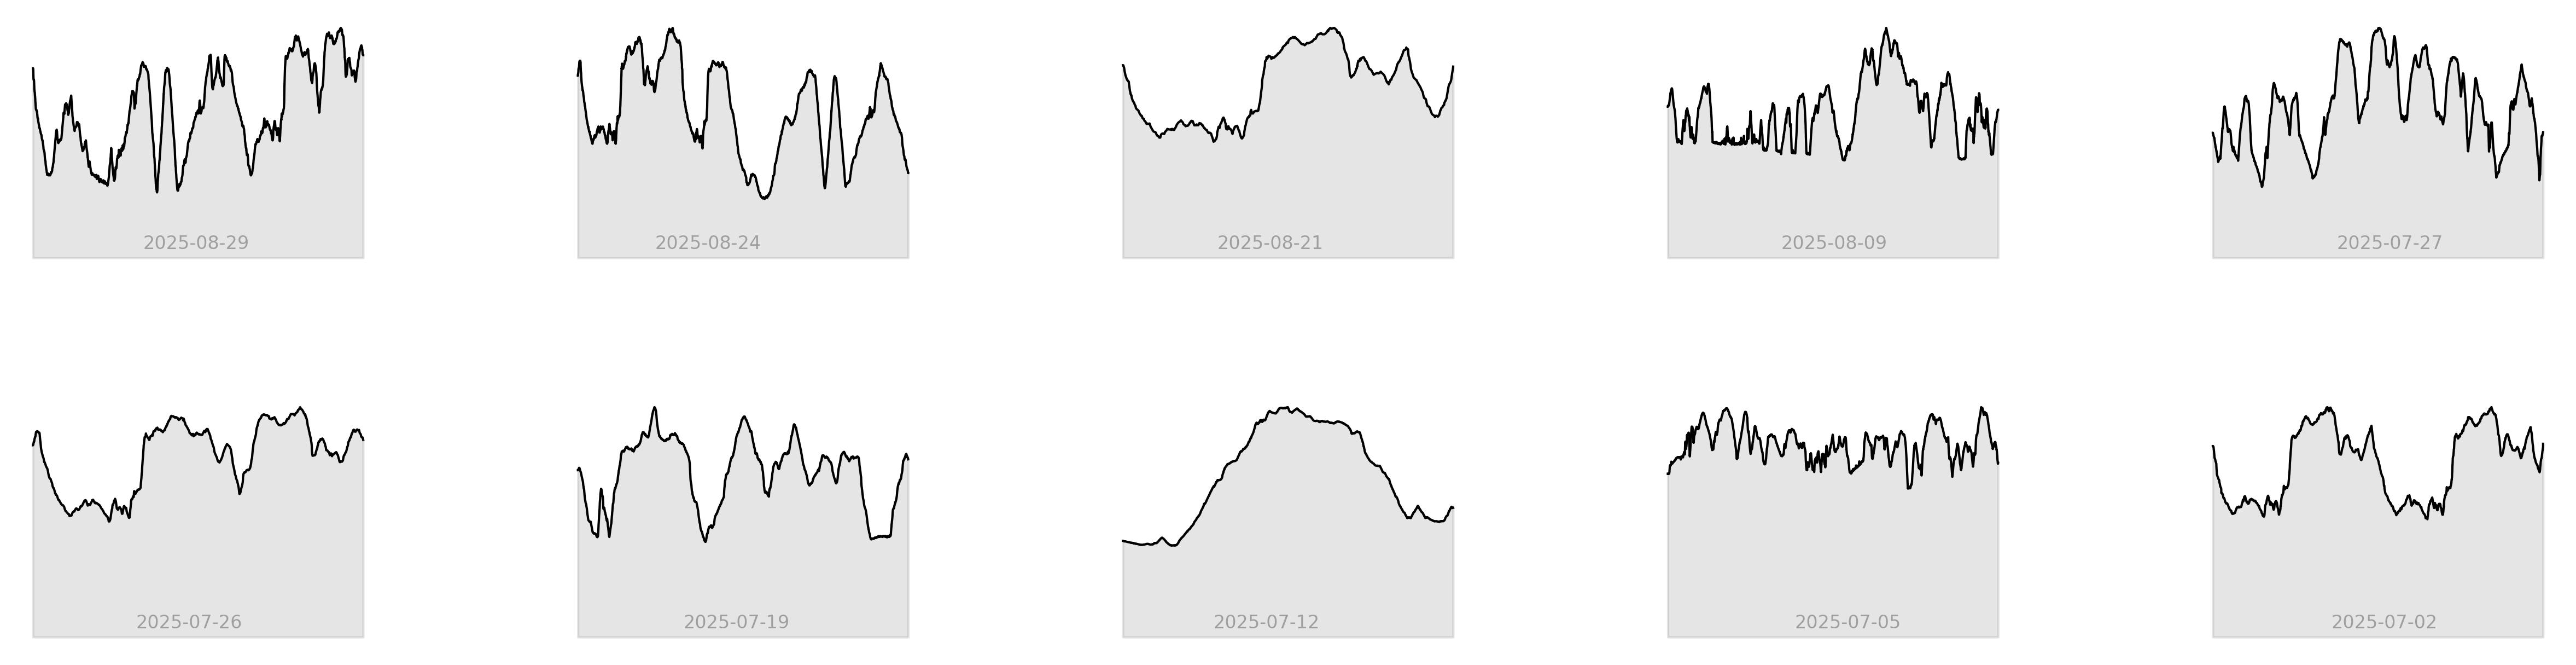

In [48]:
plot_trail_profiles(streams, df_trail)


## Trace de l'activité

In [ ]:

import polyline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import json

# Ton string JSON
json_str = """{"id": "a15533644587", "summary_polyline": "qgotHkgn[[HKZEBMCMKY[k@cAa@k@U@aCl@}@^gDx@a@Ni@Lw@VeA`@uBj@a@Pi@LCALe@Jq@Lk@n@qB`ByDzBsFxAmCzAcCVy@FUDm@?o@FoCH_BJcAEEIB[Xc@j@g@t@c@Z[\\\\YXkBlCe@^]JIQFi@QQ]@MBg@oAa@k@c@HYCEBKIYCOBCFDNIvADj@DPCVi@r@OXUPS\\\\Ub@URCHQTSNW?UEg@]ACH_@TQVKBGPBPARORSB]@CN?TWP]H_@N}ABk@?aAHeADI@OIk@?KMWOQQi@Eq@GWBQ]y@YmAGe@o@}DMq@Og@U}AYgAxA{AlAaC\\\\]X]pAw@~@{@f@UFKh@QxBoAr@QbA@h@Gr@At@MXGPKl@@d@Dx@MXK`AG^I`@@~@W\\\\E`@@h@?\\\\BXJABKN_@PQ`@@x@Lv@JpAQlASp@@RL`@NNJT`Az@NbAH`AGZINo@h@MjACb@Ux@e@|@[x@CZBPAh@Lf@v@pANNV^Tb@Ab@CLDN@Z_@f@}@RWZQj@NtEC|@I`@Y^Ol@Fd@DLbAbBz@hAf@Rf@Dr@AN\\\\@LWl@q@p@MFgAVc@Re@Lu@XYRk@d@kAj@oEzAoA\\\\|B{@PINQf@QlA]`@EDNN\\\\bAbBLHHANGFI", "resource_state": 2}"""

# Charger le JSON et décoder la polyline
data = json.loads(json_str)
coords = polyline.decode(data["summary_polyline"])
lats, lons = zip(*coords)

# Créer un dégradé le long de la trace
points = np.array([lons, lats]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
from matplotlib.collections import LineCollection

# Couleurs dégradées
norm = plt.Normalize(0, len(segments))
lc = LineCollection(segments, cmap='viridis', norm=norm, linewidth=3)
lc.set_array(np.arange(len(segments)))

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.add_collection(lc)
ax.scatter(lons[0], lats[0], color="green", s=50, label="Départ")
ax.scatter(lons[-1], lats[-1], color="red", s=50, label="Arrivée")
ax.set_axis_off()
plt.show()

# Tracer la ligne noire
plt.figure(figsize=(8, 8))
plt.plot(lons, lats, color="black", linewidth=2)
plt.axis('off')      # cacher axes, ticks et cadre
plt.gca().set_aspect('equal')  # garder les proportions
plt.show()


In [4]:
df = pd.read_csv("/Users/arthurdercq/code/Data Science/Garmin_Dashboard/data/clean_data_2025-08-28.csv")

In [ ]:
import json
import polyline
import matplotlib.pyplot as plt
import math
import pandas as pd

def plot_mini_maps_grid(df):

    plt.rcParams["figure.dpi"] = 300   # rendu à l'écran

    # --- Filtrage sur 2025 et Run/Trail ---
    df_filtered = df[
        (pd.to_datetime(df["start_date"]).dt.year == 2025) &
        (df["sport_type"].isin(["Run", "Trail"]))
    ].copy()

    # --- Supprimer activités sans map ou polyline ---
    df_filtered = df_filtered[
        df_filtered["map"].apply(lambda x: bool(json.loads(x).get("summary_polyline")))
    ]

    # Trier du plus ancien au plus récent
    df_filtered = df_filtered.sort_values("start_date", ascending=True)

    n = len(df_filtered)
    if n == 0:
        print("Aucune activité Run ou Trail en 2025 avec polyline")
        return None

    # --- Calcul grille dynamique ---
    n_cols = math.ceil(math.sqrt(n))
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows), gridspec_kw={"wspace": 0.5, "hspace": 0.5})
    axes = axes.flatten()

    for i, (_, activity) in enumerate(df_filtered.iterrows()):
        try:
            map_json = json.loads(activity["map"])
            polyline_str = map_json.get("summary_polyline")
            coords = polyline.decode(polyline_str)
            lats, lons = zip(*coords)

            axes[i].plot(lons, lats, color="black", linewidth=0.3)
            axes[i].axis("off")
            axes[i].set_aspect("equal")
        except Exception as e:
            print(f"Erreur activité {activity['activity_id']}: {e}")

    # Cases vides (si grille > n)
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    return fig


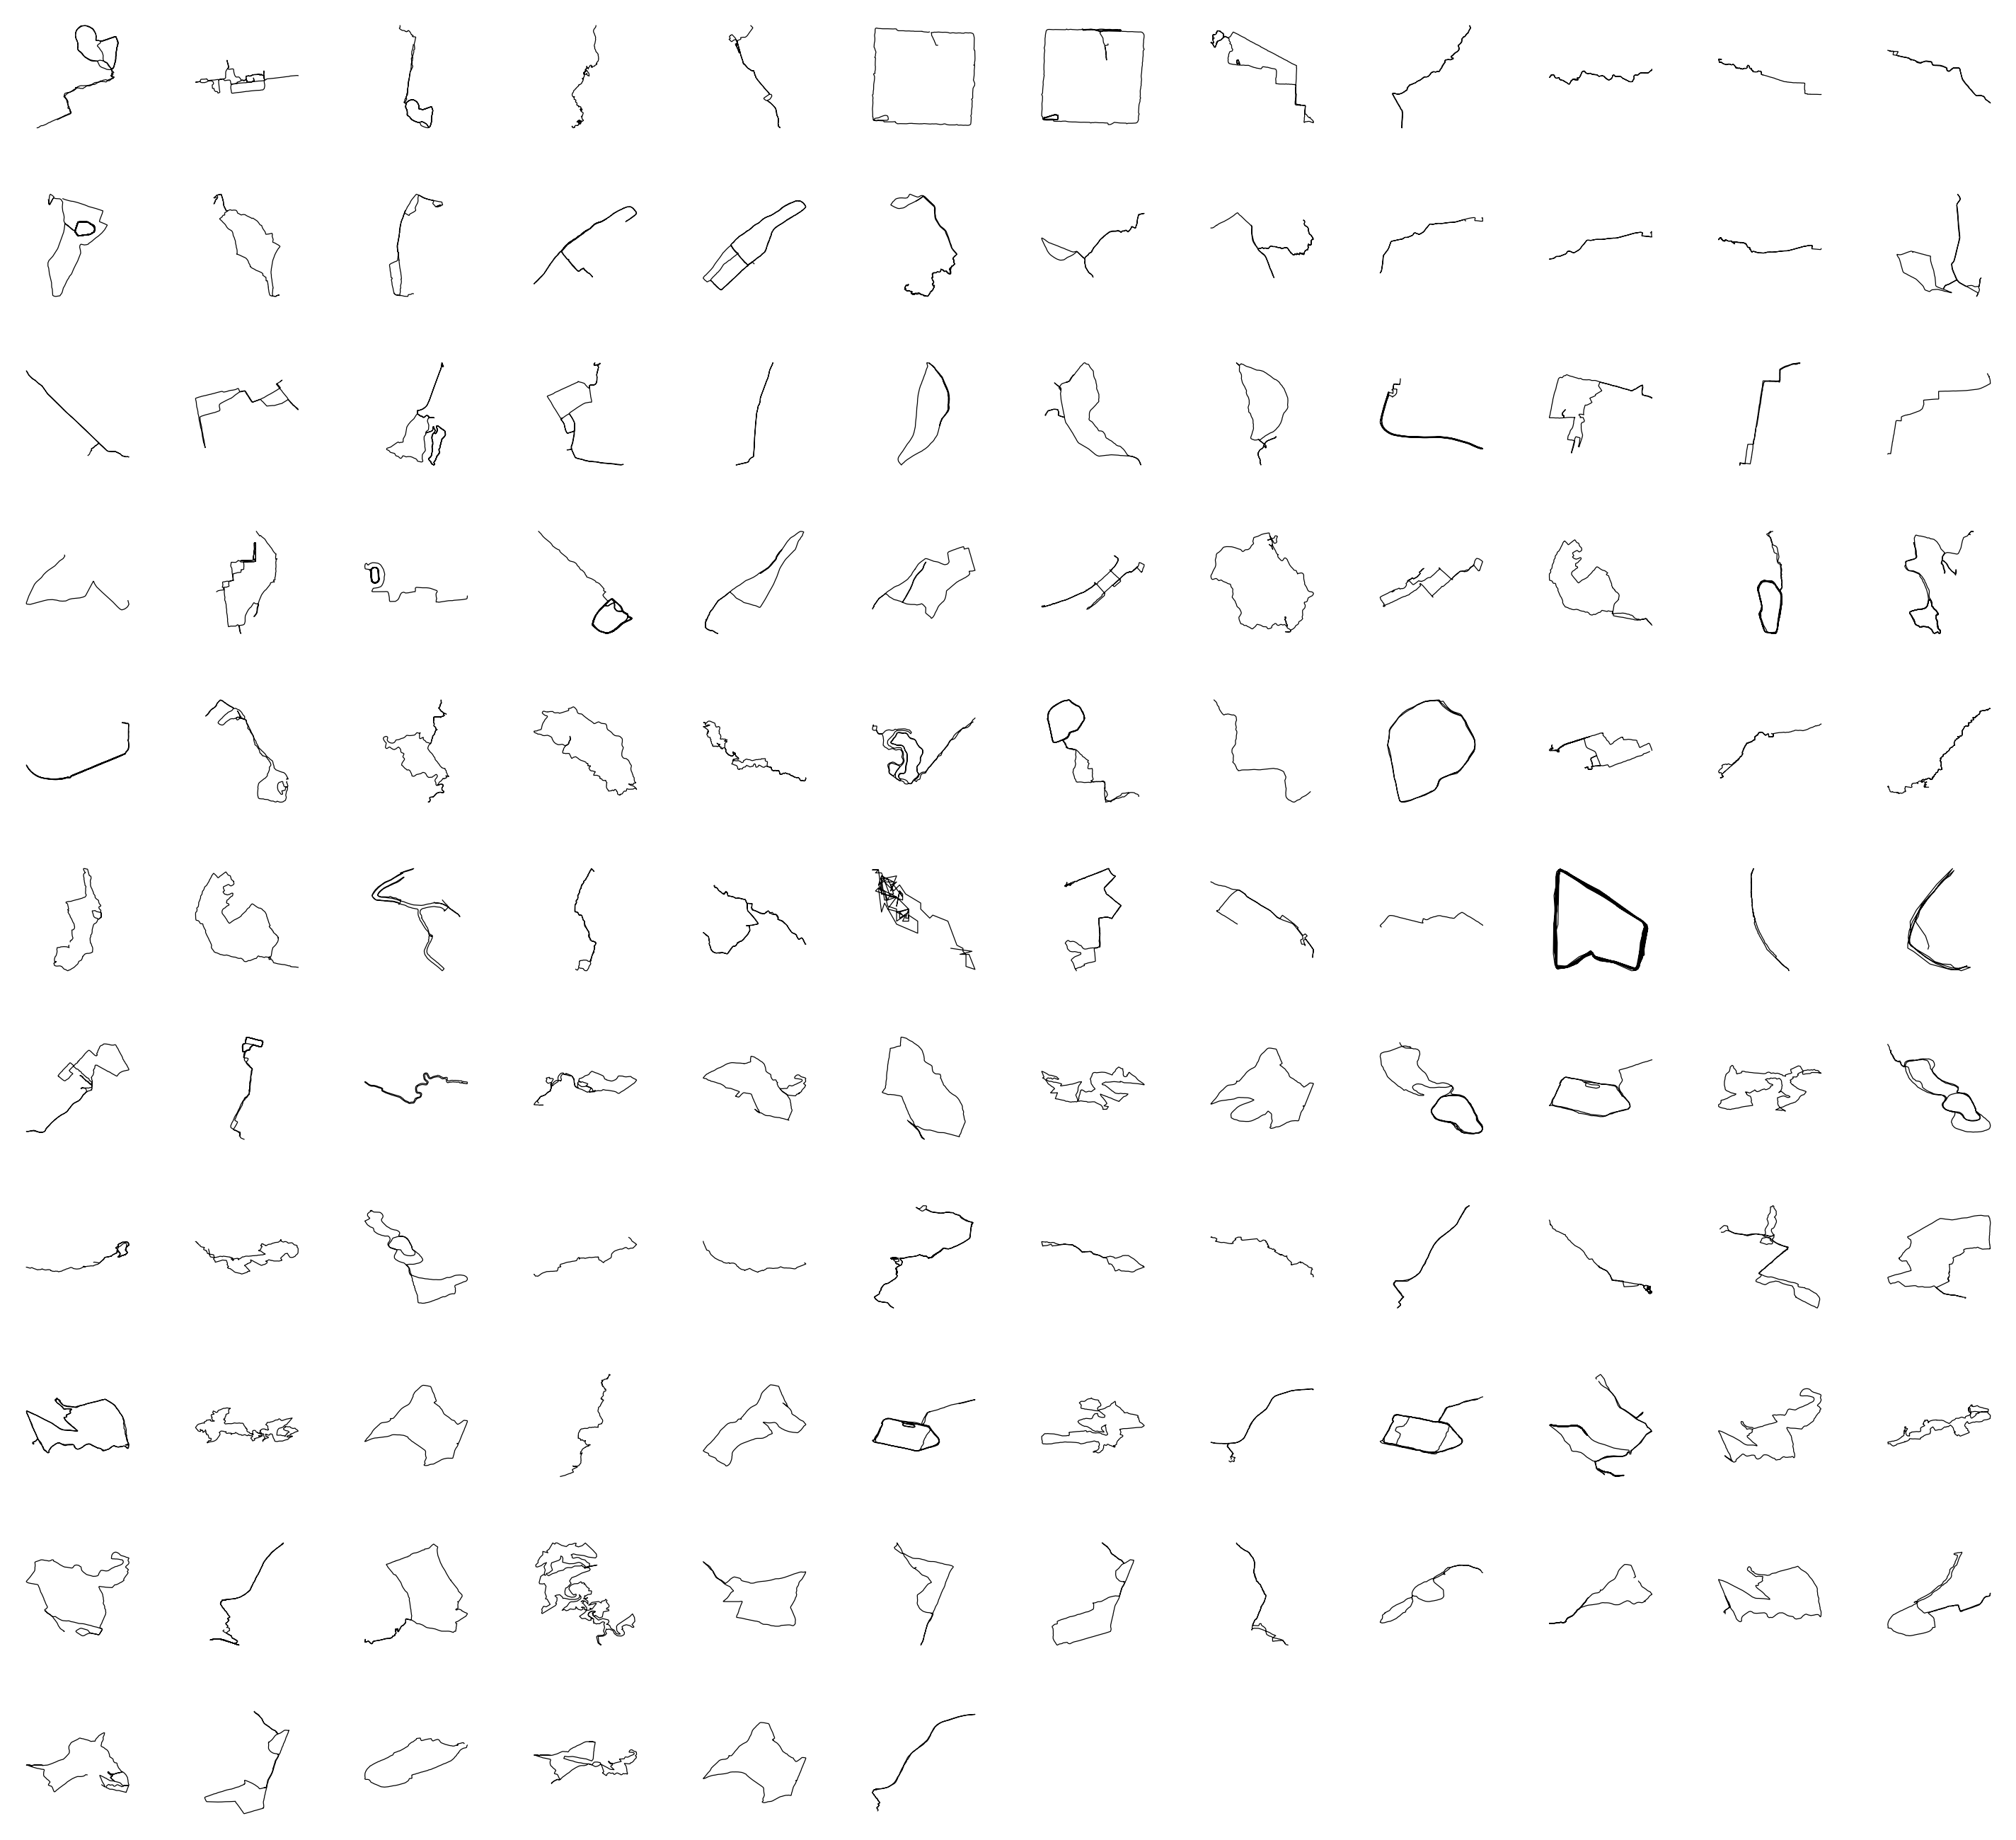

In [2]:
df = pd.read_csv("/Users/arthurdercq/code/Data Science/Garmin_Dashboard/data/clean_data_2025-09-02.csv")
fig = plot_mini_maps_grid(df)
plt.show()

## Plot Calendar

In [28]:
from __future__ import annotations

import calmap
#https://pythonhosted.org/calmap/
import matplotlib.pyplot as plt
import pandas as pd

ACTIVITY_FORMAT = "%b %d, %Y, %H:%M:%S %p"


def plot_calendar(
    df,
    year_min=None,
    year_max=None,
    max_dist=None,
    fig_height=15,
    fig_width=9,
    output_file="calendar.png",
):
    # Create a new figure
    plt.figure()

    # Process data
    df["start_date"] = pd.to_datetime(
        df["start_date"], format=ACTIVITY_FORMAT
    )
    df["date"] = df["start_date"].dt.date
    df = df.groupby(["date"])["distance"].sum()
    df.index = pd.to_datetime(df.index)
    df.clip(0, max_dist, inplace=True)

    if year_min:
        df = df[df.index.year >= year_min]

    if year_max:
        df = df[df.index.year <= year_max]

    # Create heatmap
    fig, ax = calmap.calendarplot(data=df)

    # Save plot
    fig.set_figheight(fig_height)
    fig.set_figwidth(fig_width)
    fig.savefig(output_file, dpi=600)

<Figure size 640x480 with 0 Axes>

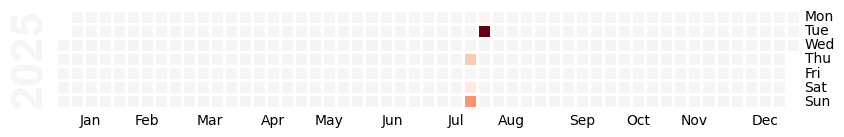

In [29]:
plot_calendar(df)

## Intensity week

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime
import streamlit as st

In [ ]:
today = pd.Timestamp.today().normalize()
week_offset = -1
week_start = today - pd.to_timedelta(today.weekday(), unit="D") + pd.Timedelta(weeks=week_offset)
week_end = week_start + pd.Timedelta(days=6)
# 🎨 Palette couleurs graphique
SPORT_COLORS = {
    "Run": "#ff7f0e",       # orange
    "TrailRun": "#ff7f0e",  # même que Run
    "Ride": "#1f77b4",      # bleu
    "Swim": "#2ca02c",      # vert
    "Workout" : "#5C92D1"
}

def plot_weekly_intensity(df, week_start, week_end):

    df["start_date"] = pd.to_datetime(df["start_date"]).dt.tz_localize(None)
    df_week = df[(df["start_date"] >= week_start) & (df["start_date"] <= week_end)].copy()
    print(df['start_date'].min(), df['start_date'].max())

    if df_week.empty:
        print("Aucune activité sur cette semaine")
        return

    df_week["day"] = df_week["start_date"].dt.day_name(locale="fr_FR").str.lower()  # "lundi", "mardi", etc.
    print(f"{len(df_week)} activités cette semaine")
    # Ordre fixe des jours (toujours lundi→dimanche)
    days_order = ["lundi","mardi","mercredi","jeudi","vendredi","samedi","dimanche"]


    # Agrégation par jour + sport
    df_grouped = (
        df_week.groupby(["day","sport_type"])["elapsed_time"]
        .sum()
        .reset_index()
    )
    print("df_grouped : ", df_grouped)
    # Pivot pour barres empilées
    df_pivot = df_grouped.pivot(index="day", columns="sport_type", values="elapsed_time").fillna(0)
    df_pivot = df_pivot.reindex(days_order)
    print(df_pivot)

    # --- Graphique ---
    fig, ax = plt.subplots(figsize=(7,3))

    df_pivot.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[SPORT_COLORS.get(s, "gray") for s in df_pivot.columns]
    )

    # Style épuré
    ax.set_ylabel("Minutes")
    ax.set_xlabel("")
    ax.set_xticklabels([d.capitalize() for d in days_order])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(frameon=False, bbox_to_anchor=(1,1))

    return fig

In [5]:
df = pd.read_csv("/Users/arthurdercq/code/Data Science/Garmin_Dashboard/data/clean_data_2025-08-19.csv")

In [18]:
df.dtypes

name                                object
distance                           float64
moving_time                        float64
elapsed_time                       float64
total_elevation_gain               float64
sport_type                          object
id                                   int64
start_date                  datetime64[ns]
start_date_local                    object
timezone                            object
achievement_count                    int64
kudos_count                          int64
map                                 object
gear_id                             object
start_latlng                        object
end_latlng                          object
average_speed                      float64
max_speed                          float64
average_cadence                    float64
average_temp                       float64
has_heartrate                         bool
average_heartrate                  float64
max_heartrate                      float64
elev_high  

2019-04-06 12:14:07 2025-08-17 17:02:50
6 activités cette semaine
df_grouped :          day sport_type  elapsed_time
0     jeudi        Run     31.583333
1     jeudi    Workout     56.383333
2     mardi       Swim     45.216667
3  mercredi        Run     37.866667
4    samedi       Ride     95.183333
5    samedi        Run     65.783333
sport_type       Ride        Run       Swim    Workout
day                                                   
lundi             NaN        NaN        NaN        NaN
mardi        0.000000   0.000000  45.216667   0.000000
mercredi     0.000000  37.866667   0.000000   0.000000
jeudi        0.000000  31.583333   0.000000  56.383333
vendredi          NaN        NaN        NaN        NaN
samedi      95.183333  65.783333   0.000000   0.000000
dimanche          NaN        NaN        NaN        NaN


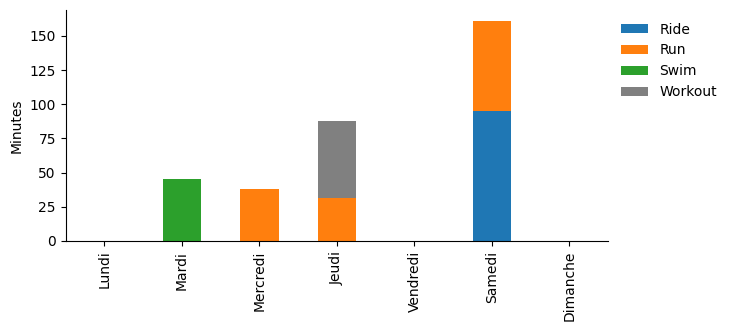

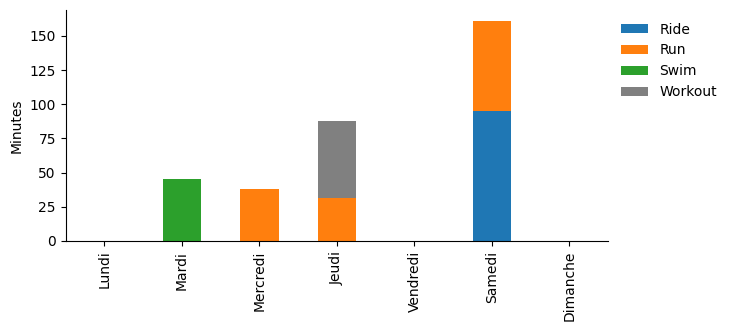

In [20]:
plot_weekly_intensity(df, week_start, week_end)